In [25]:
import numpy             as np
import pandas            as pd
import matplotlib.pyplot as plt
import seaborn           as sns

from DataFormat  import DataFormat
from read_data   import read_data
from calibration import read_calibration_parameters, linear_calibration

from matplotlib.colors import LogNorm

## Constants

In [26]:
DATA_PATH   = "./data"
DATA_PREFIX = "beam-analysis-day"

LABR_A  = "labr-a"
LABR_B  = "labr-b"
CLYC    = "clyc"
PLASTIC = "plastic"

## Read data

In [27]:
run_day  = 3

data_labr_a = read_data(DATA_PATH, f"{DATA_PREFIX}{run_day}.root", DataFormat(LABR_A))
data_labr_b = read_data(DATA_PATH, f"{DATA_PREFIX}{run_day}.root", DataFormat(LABR_B))

data_clyc = pd.read_csv(f"{DATA_PATH}/data_clyc_with_cluster_day{run_day}.csv", sep=',')

In [28]:
# clean data from saturated events
data_labr_a = data_labr_a[data_labr_a["energy"] < data_labr_a["energy"].max()]
data_labr_b = data_labr_b[data_labr_b["energy"] < data_labr_b["energy"].max()]

# clean data from zero energy events
data_labr_a = data_labr_a[data_labr_a["energy"] > 0]
data_labr_b = data_labr_b[data_labr_b["energy"] > 0]

## Calibration

In [29]:
param_labr_a = read_calibration_parameters(
    "./calibration-parameters/labr_a_linear_parameters.txt"
)

param_labr_b = read_calibration_parameters(
    "./calibration-parameters/labr_b_linear_parameters.txt"
)

In [30]:
data_labr_a.loc[:, "energy_calib"]       = linear_calibration(data_labr_a["energy"], param_labr_a)
data_labr_a.loc[:, "energy_short_calib"] = linear_calibration(data_labr_a["energy_short"], param_labr_a)

data_labr_b.loc[:, "energy_calib"]       = linear_calibration(data_labr_b["energy"], param_labr_b)
data_labr_b.loc[:, "energy_short_calib"] = linear_calibration(data_labr_b["energy_short"], param_labr_b)

In [31]:
def compute_psd(df):
    return (df["energy"] - df["energy_short"]) / df["energy"]

def compute_psd_calib(df):
    return (df["energy_calib"] - df["energy_short_calib"]) / df["energy_calib"]

data_labr_a.loc[:, "psd"] = compute_psd(data_labr_a)
data_labr_b.loc[:, "psd"] = compute_psd(data_labr_b)
data_labr_a.loc[:, "psd_calib"] = compute_psd_calib(data_labr_a)
data_labr_b.loc[:, "psd_calib"] = compute_psd_calib(data_labr_b)

In [32]:
# remove all points that have a psd or psd_calib value greater than 1
def remove_psd_outliers(df):
    return df[(df["psd"] < 1) & (df["psd_calib"] < 1)]

data_labr_a = remove_psd_outliers(data_labr_a)
data_labr_b = remove_psd_outliers(data_labr_b)

In [33]:
# add an ID column to the dataframes that ranges from 0 to the number of events
data_labr_a.loc[:, "id"] = np.arange(len(data_labr_a))
data_labr_b.loc[:, "id"] = np.arange(len(data_labr_b))

In [34]:
data_clyc

,board,channel,flag,timestamp,energy,energy_short,energy_calib,energy_short_calib,psd,psd_calib,id,Particle
0,1,2,16384,3373955702,184,73,901.837975,339.812658,0.603261,0.623200,0,Gamma
1,1,2,16384,10480929968,80,32,375.255696,132.217722,0.600000,0.647660,1,Gamma
2,1,2,16384,13610683468,116,47,557.534177,208.167089,0.594828,0.626629,2,Gamma
3,1,2,16384,24705541682,649,266,3256.268354,1317.027848,0.590139,0.595541,3,Gamma
4,1,2,16384,29984914781,42,18,182.850633,61.331646,0.571429,0.664581,4,Gamma
...,...,...,...,...,...,...,...,...,...,...,...,...
2952717,1,2,16384,15868456498226562,96,39,456.268354,167.660759,0.593750,0.632539,3223244,Gamma
2952718,1,2,16384,15868464323128029,104,47,496.774684,208.167089,0.548077,0.580963,3223245,Gamma
2952719,1,2,16384,15868474285595217,62,26,284.116456,101.837975,0.580645,0.641563,3223246,Gamma
2952720,1,2,16384,15868474360183998,54,21,243.610127,76.521519,0.611111,0.685885,3223247,Gamma


## CLYC PID CHECK

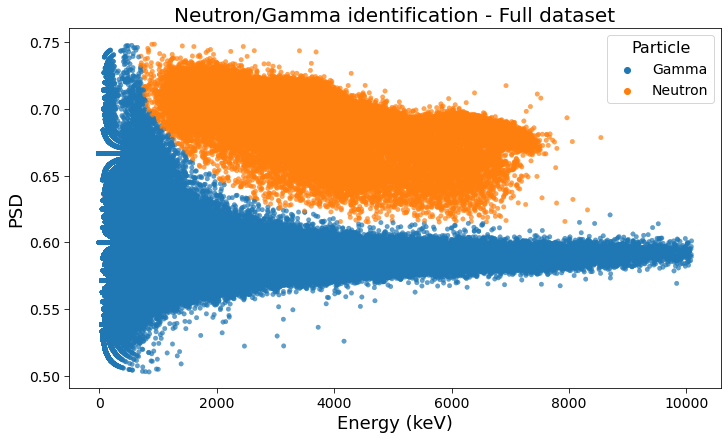

In [12]:
fig, ax = plt.subplots(figsize=(10, 6), constrained_layout=True)

sns.scatterplot(x='energy_calib', y='psd', hue='Particle', data=data_clyc, palette="tab10", alpha=0.7, edgecolor=None, ax=ax, s=20, legend=True)


ax.set_title('Neutron/Gamma identification - Full dataset', fontsize=20)
ax.set_xlabel('Energy (keV)', fontsize=18)
ax.set_ylabel('PSD', fontsize=18)


ax.tick_params(axis="both", which="major", labelsize=14, length=5)

ax.legend(fontsize=14, title_fontsize=16, title="Particle", loc="upper right")


plt.show()

## COINCIDENCE

In [35]:
# select neutrons from the clyc data
clyc_neutrons = data_clyc[data_clyc["Particle"] == "Neutron"]

clyc_neutrons.shape

(90276, 12)

In [36]:
clyc_neutrons.head()

,board,channel,flag,timestamp,energy,energy_short,energy_calib,energy_short_calib,psd,psd_calib,id,Particle
6,1,2,16384,36343587968,515,148,2577.787342,719.559494,0.712621,0.720862,6,Neutron
10,1,2,16384,41925592312,461,140,2304.369620,679.053165,0.696312,0.705319,10,Neutron
47,1,2,16384,174346159999,736,227,3696.774684,1119.559494,0.691576,0.697152,50,Neutron
58,1,2,16384,213331022952,485,146,2425.888608,709.432911,0.698969,0.707558,62,Neutron
70,1,2,16384,251751567530,480,143,2400.572152,694.243038,0.702083,0.710801,75,Neutron


In [37]:
# add a PArticle column to the labr data with the value "Gamma" for all events
data_labr_a.loc[:, "Particle"] = "Gamma"

In [38]:
# add a PArticle column to the labr data with the value "Gamma" for all events
data_labr_b.loc[:, "Particle"] = "Gamma"

In [21]:
data_labr_a.head()

,board,channel,flag,timestamp,energy,energy_short,energy_calib,energy_short_calib,psd,psd_calib,id,Particle
0,1,1,16384,185491138,167,166,564.173312,560.868330,0.005988,0.005858,0,Gamma
1,1,1,16384,2107502654,36,36,131.220674,131.220674,0.000000,0.000000,1,Gamma
2,1,1,16384,6119960866,276,275,924.416347,921.111365,0.003623,0.003575,2,Gamma
3,1,1,16384,7104383718,152,151,514.598583,511.293601,0.006579,0.006422,3,Gamma
4,1,1,16384,8418481686,38,38,137.830638,137.830638,0.000000,0.000000,4,Gamma


In [22]:
data_labr_b.head()

,board,channel,flag,timestamp,energy,energy_short,energy_calib,energy_short_calib,psd,psd_calib,id,Particle
0,1,0,16384,864787515,143,143,515.878331,515.878331,0.000000,0.00000,0,Gamma
1,1,0,16384,5808301843,79,79,290.457641,290.457641,0.000000,0.00000,1,Gamma
2,1,0,16384,6419561295,105,104,382.034796,378.512598,0.009524,0.00922,2,Gamma
3,1,0,16384,8906369576,157,157,565.189107,565.189107,0.000000,0.00000,3,Gamma
4,1,0,16384,10779470014,151,151,544.055917,544.055917,0.000000,0.00000,4,Gamma


In [23]:
# time windows (in picoseconds) to check for coincidences
time_windows = [50000, 100000, 500000, 1000000, 5000000, 10000000, 50000000, 100000000]


### LABR A ###
def check_timestamps_a(row, tw):
    global result_a
    
    # Get the timestamp of the current row
    timestamp = row['timestamp']

    # Find rows in the data_labr_a dataframe with timestamps within 100 nanoseconds of the current row's timestamp
    mask = (data_labr_a['timestamp'] >= timestamp - tw//2) & (data_labr_a['timestamp'] <= timestamp + tw//2)
    matching_rows = data_labr_a[mask]

    # If there are any matching rows, add them and the current row to the result dataframe
    if len(matching_rows) > 0:
        result_a = result_a.append(row, ignore_index=True)
        result_a = result_a.append(matching_rows, ignore_index=True)
        
        
### LABR B ###
def check_timestamps_b(row, tw):
    global result_b
    
    # Get the timestamp of the current row
    timestamp = row['timestamp']

    # Find rows in the data_labr_a dataframe with timestamps within 100 nanoseconds of the current row's timestamp
    mask = (data_labr_b['timestamp'] >= timestamp - tw//2) & (data_labr_b['timestamp'] <= timestamp + tw//2)
    matching_rows = data_labr_b[mask]

    # If there are any matching rows, add them and the current row to the result dataframe
    if len(matching_rows) > 0:
        result_b = result_b.append(row, ignore_index=True)
        result_b = result_b.append(matching_rows, ignore_index=True)
        
# Loop through the time windows and check for coincidences
for tw in time_windows:
    
    print(f"Checking for coincidences within {tw/1000} nanoseconds...")
    
    
    result_a = pd.DataFrame(columns=['board', 'channel', 'flag', 'timestamp', 'energy', 'energy_short', 'energy_calib', 'energy_short_calib', 'psd', 'psd_calib', 'id', 'Particle'])
    clyc_neutrons.apply(check_timestamps_a, axis=1, args=(tw,))
    
    print(f"Found {len(result_a)} coincidences within {tw/1000} nanoseconds.")
    result_a.to_csv(f"{DATA_PATH}/labra-coincidence-day{run_day}-{tw//1000}ns.csv", index=False)
    
    result_b = pd.DataFrame(columns=['board', 'channel', 'flag', 'timestamp', 'energy', 'energy_short', 'energy_calib', 'energy_short_calib', 'psd', 'psd_calib', 'id', 'Particle'])
    clyc_neutrons.apply(check_timestamps_b, axis=1, args=(tw,))
    
    print(f"Found {len(result_b)} coincidences within {tw/1000} nanoseconds.")
    result_b.to_csv(f"{DATA_PATH}/labrb-coincidence-day{run_day}-{tw//1000}ns.csv", index=False)
    
    
    print(f"Done checking for coincidences within {tw/1000} nanoseconds.")
    

Checking for coincidences within 50.0 nanoseconds...
Found 792 coincidences within 50.0 nanoseconds.
Found 152 coincidences within 50.0 nanoseconds.
Done checking for coincidences within 50.0 nanoseconds.
Checking for coincidences within 100.0 nanoseconds...
Found 802 coincidences within 100.0 nanoseconds.
Found 168 coincidences within 100.0 nanoseconds.
Done checking for coincidences within 100.0 nanoseconds.
Checking for coincidences within 500.0 nanoseconds...
Found 848 coincidences within 500.0 nanoseconds.
Found 192 coincidences within 500.0 nanoseconds.
Done checking for coincidences within 500.0 nanoseconds.
Checking for coincidences within 1000.0 nanoseconds...
Found 904 coincidences within 1000.0 nanoseconds.
Found 228 coincidences within 1000.0 nanoseconds.
Done checking for coincidences within 1000.0 nanoseconds.
Checking for coincidences within 5000.0 nanoseconds...
Found 1296 coincidences within 5000.0 nanoseconds.
Found 556 coincidences within 5000.0 nanoseconds.
Done che

In [24]:
# read in the coincidence data
test = pd.read_csv(f"{DATA_PATH}/labra-coincidence-day3-50ns.csv")
test

,board,channel,flag,timestamp,energy,energy_short,energy_calib,energy_short_calib,psd,psd_calib,id,Particle
0,1,2,16384,77998495846326,551,172,2760.065823,841.078481,0.687840,0.695269,21022,Neutron
1,1,1,16384,77998495843123,83,82,286.554826,283.249844,0.012048,0.011534,53520,Gamma
2,1,2,16384,219043323203373,624,186,3129.686076,911.964557,0.701923,0.708608,58678,Neutron
3,1,1,16384,219043323204716,240,239,805.436996,802.132014,0.004167,0.004103,148202,Gamma
4,1,2,16384,221870125422170,580,174,2906.901266,851.205063,0.700000,0.707178,59422,Neutron
...,...,...,...,...,...,...,...,...,...,...,...,...
787,1,1,16384,15733584262813604,600,598,1995.230507,1988.620543,0.003333,0.003313,8453948,Gamma
788,1,2,16384,15748126962104686,821,280,4127.154430,1387.913924,0.658952,0.663712,3200474,Neutron
789,1,1,16384,15748126962108062,89,88,306.384718,303.079736,0.011236,0.010787,8461272,Gamma
790,1,2,16384,15788000214002702,621,191,3114.496203,937.281013,0.692432,0.699059,3208043,Neutron


## One-sided coincidence

In [ ]:
# time windows (in picoseconds) to check for coincidences
time_windows = [25000, 50000, 100000]


### LABR A ###
def check_timestamps_a(row, tw):
    global result_a
    
    # Get the timestamp of the current row
    timestamp = row['timestamp']

    # Find rows in the data_labr_a dataframe with timestamps within 100 nanoseconds of the current row's timestamp
    mask = (data_labr_a['timestamp'] >= timestamp - tw//2) & (data_labr_a['timestamp'] <= timestamp + tw//2)
    matching_rows = data_labr_a[mask]

    # If there are any matching rows, add them and the current row to the result dataframe
    if len(matching_rows) > 0:
        result_a = result_a.append(row, ignore_index=True)
        result_a = result_a.append(matching_rows, ignore_index=True)
        
        
### LABR B ###
def check_timestamps_b(row, tw):
    global result_b
    
    # Get the timestamp of the current row
    timestamp = row['timestamp']

    # Find rows in the data_labr_a dataframe with timestamps within 100 nanoseconds of the current row's timestamp
    mask = (data_labr_b['timestamp'] >= timestamp - tw//2) & (data_labr_b['timestamp'] <= timestamp + tw//2)
    matching_rows = data_labr_b[mask]

    # If there are any matching rows, add them and the current row to the result dataframe
    if len(matching_rows) > 0:
        result_b = result_b.append(row, ignore_index=True)
        result_b = result_b.append(matching_rows, ignore_index=True)
        
# Loop through the time windows and check for coincidences
for tw in time_windows:
    
    print(f"Checking for coincidences within {tw/1000} nanoseconds...")
    
    
    result_a = pd.DataFrame(columns=['board', 'channel', 'flag', 'timestamp', 'energy', 'energy_short', 'energy_calib', 'energy_short_calib', 'psd', 'psd_calib', 'id', 'Particle'])
    clyc_neutrons.apply(check_timestamps_a, axis=1, args=(tw,))
    
    print(f"Found {len(result_a)} coincidences within {tw/1000} nanoseconds.")
    result_a.to_csv(f"{DATA_PATH}/labra-coincidence-day{run_day}-{tw//1000}ns.csv", index=False)
    
    result_b = pd.DataFrame(columns=['board', 'channel', 'flag', 'timestamp', 'energy', 'energy_short', 'energy_calib', 'energy_short_calib', 'psd', 'psd_calib', 'id', 'Particle'])
    clyc_neutrons.apply(check_timestamps_b, axis=1, args=(tw,))
    
    print(f"Found {len(result_b)} coincidences within {tw/1000} nanoseconds.")
    result_b.to_csv(f"{DATA_PATH}/labrb-coincidence-day{run_day}-{tw//1000}ns.csv", index=False)
    
    
    print(f"Done checking for coincidences within {tw/1000} nanoseconds.")
    